# TME3: How Much Did It Rain? II

https://www.kaggle.com/c/how-much-did-it-rain-ii


Car cancellation guide:
https://github.com/numb3r33/Kaggle-Competitions/blob/master/cars-cancellation/cars_cancellation.ipynb


En pluviométrie, pour mesurer les hauteurs des précipitations on utilise des jauges qui receuillent la pluie. On est alors capable de déterminer la quantité d'eau tombée durant un intervalle de temps donné, ici une heure.
Cependant, les jauges ne peuvent pas couvrir l'ensemble des lieux que l'on souhaite observer. On utilise alors des radars et on estime la hauteur des précipitations à partir de leurs relevés.
Cependant, ces estimations correspondent mal aux mesures effectués sur les jauges.
L'objectif de ce challenge est de fournir un meilleur estimateur basée sur les relevés des radars.

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sb
%matplotlib inline  

from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import mean_absolute_error

# Chargement des données

Les données sont des séquences de relevés de capteurs sur une durée d'une heure à des temps variables.
A chaque séquence est associée un identifiant et la distance du capteur à une jauge dont il faut prédire les mesures à la fin de l'heure.
Un élément de la séquence contient les différentes mesures effectués par le radar à un instant donné.

In [2]:
%%time
dfTrain = pd.read_csv('./data/train.csv')

CPU times: user 32.9 s, sys: 10.8 s, total: 43.7 s
Wall time: 45.3 s


In [3]:
dfTrain['Id_index'] = dfTrain['Id']

In [4]:
dfTrain = dfTrain.set_index('Id_index')

# Premier aperçu

On commence par regarder succintement les données. On cherche à répondre à des questions d'ordre général sur les données:
Nombre de séquences et nombre de relevés, nombre de dimension, il y a-t-il des dimensions catégorielles à traiter et y a-t-il des données manquantes?

Un premier résumé permet de dire qu'il y a 13765201 entrées de 24 dimensions (23 si on exclu la quantité a prédire), toutes numériques.
On voit aussi en extrayant la tête et la queue de la table qu'il y a un certain nombre de données manquantes et qu'il y a 1180945 séquences.

In [118]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13765201 entries, 1 to 1180945
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.6 GB


In [119]:
dfTrain.head(10)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
1,1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,55,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,2,1,2,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
2,2,6,2,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016
2,2,11,2,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016


In [120]:
dfTrain.tail(10)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
1180945,1180945,14,9,33.5,NaN,32.5,46.5,35.5,6.5,35.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,19,9,43.5,9.5,39.0,49.5,43.5,15.5,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,24,9,31.5,19.5,31.5,41.0,31.5,20.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,28,9,24.0,25.5,31.0,41.0,24.0,25.5,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,33,9,25.5,22.0,27.0,31.0,29.0,25.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,38,9,33.0,19.5,25.5,36.5,33.0,20.5,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,42,9,33.0,21.0,30.5,37.0,36.5,22.0,33.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,47,9,29.5,10.0,26.0,30.5,31.0,16.5,26.0,...,1.051667,1.75,NaN,0.750,3.0000,13.379990,NaN,NaN,13.379990,8.636004
1180945,1180945,52,9,19.0,NaN,15.5,26.5,19.0,NaN,16.5,...,1.051667,NaN,NaN,NaN,2.8125,NaN,NaN,NaN,NaN,8.636004


## Distribution des données

On s'intéresse à la distribution des données, en particulier la quantité de données manquantes et la distribution de la quantité à prédire.

La ligne count nous permet d'évaluer que pour la plupart des colonnes, environ la moitié des données sont manquantes.
La distribution de la colonne Expected est particulière dans le sens où les 3 premiers quartiles sont très bas (respectivement 0.25, 1.02 et 3.81) alors que la moyenne est à 108.63 et le maximum à 33017.73.
C'est-à-dire que la grande majorité des valeurs sont très petites et les grandes valeurs sont extrêmement grandes.
Ceci explique aussi le choix d'une pénalisation sur la norme L1 plutot que L2 qui risquerait de donner un poids démesuré à ces valeurs extrêmes.

In [121]:
dfTrain.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,13765201.000000,13765201.000000,13765201.000000,6349375.000000,5283988.000000,6356482.000000,7551281.000000,6716343.000000,5755673.000000,6711663.000000,...,5905584.000000,4934916.000000,4133154.000000,4936568.000000,5905584.000000,4182635.000000,3428782.000000,4187281.000000,5052776.000000,13765201.000000
mean,592336.986614,29.523733,11.067943,22.926658,19.952271,22.610287,25.898461,24.711081,22.158238,24.420753,...,1.015272,0.536709,-0.719008,0.337622,2.072870,0.035452,-3.482325,-0.473655,4.079836,108.626306
std,340856.086254,17.308131,4.206618,10.355157,9.208166,10.053000,11.109579,10.689622,9.702705,10.424526,...,0.048616,1.510399,1.006068,0.938644,1.670194,3.869725,2.792120,2.263046,4.147337,548.605805
min,1.000000,0.000000,0.000000,-31.000000,-32.000000,-32.000000,-28.500000,-32.000000,-31.000000,-27.500000,...,0.208333,-7.875000,-7.875000,-7.875000,-7.875000,-96.040000,-80.790000,-78.770004,-100.200005,0.010000
25%,296897.000000,15.000000,9.000000,16.000000,14.000000,16.000000,18.000000,17.500000,16.000000,17.500000,...,0.998333,-0.187500,-1.125000,-0.062500,1.062500,-1.410004,-4.580002,-0.710007,2.069992,0.254000
50%,592199.000000,30.000000,11.000000,22.500000,20.000000,22.500000,25.500000,24.000000,22.000000,24.000000,...,1.011667,0.375000,-0.625000,0.250000,1.687500,0.000000,-2.820007,0.000000,3.519989,1.016000
75%,889582.000000,44.000000,14.000000,29.500000,26.000000,29.000000,33.500000,31.500000,28.500000,31.500000,...,1.051667,1.062500,-0.187500,0.687500,2.625000,1.750000,-1.760010,0.349991,5.639999,3.810002
max,1180945.000000,59.000000,21.000000,71.000000,62.500000,69.000000,72.500000,92.500000,66.000000,71.000000,...,1.051667,7.937500,7.937500,7.937500,7.937500,179.750000,3.519989,12.800003,144.600000,33017.730000


### Données manquantes

Il y aurait 38% de données manquantes
https://www.kaggle.com/c/how-much-did-it-rain-ii/forums/t/16572/38-missing-data

Combien y'a-t-il de données manquantes par dimension ?

In [19]:
l = float(len(dfTrain["Id"]))
comp = []
for i in dfTrain.columns:
    comp.append([1 - dfTrain[i].isnull().sum() / l , i])
comp.sort(key=lambda x: x[0], reverse=True)
print(comp)
compA = np.array(comp)

[[1.0, 'Id'],
 [1.0, 'minutes_past'],
 [1.0, 'radardist_km'],
 [1.0, 'Expected'],
 [0.56876779351060691, 'RefComposite_5x5_90th'],
 [0.54857760522349075, 'Ref_5x5_90th'],
 [0.48792189812557041, 'RefComposite'],
 [0.48758191035495957, 'RefComposite_5x5_50th'],
 [0.46177909062134292, 'Ref_5x5_50th'],
 [0.4612627886799473, 'Ref'],
 [0.42902272186217982, 'RhoHV_5x5_90th'],
 [0.42902272186217982, 'Zdr_5x5_90th'],
 [0.41813214351174388, 'RefComposite_5x5_10th'],
 [0.38386566240478437, 'Ref_5x5_10th'],
 [0.36706881359741861, 'Kdp_5x5_90th'],
 [0.35862665572409735, 'RhoHV_5x5_50th'],
 [0.35862665572409735, 'Zdr_5x5_50th'],
 [0.35850664294695012, 'RhoHV'],
 [0.35850664294695012, 'Zdr'],
 [0.30419323335707193, 'Kdp_5x5_50th'],
 [0.30385571558308522, 'Kdp'],
 [0.30026107137847102, 'RhoHV_5x5_10th'],
 [0.30026107137847102, 'Zdr_5x5_10th'],
 [0.2490905871988357, 'Kdp_5x5_10th']]

Combien y'a-t-il de séquences totalement nulles sauf minutes_past, radardist_km et expected ?
> environ 40% du trainset ne possède que des features nulles

In [85]:
dfLight = dfTrain.drop(['minutes_past','radardist_km', 'Expected'],axis=1)
nbIds = len(dfLight.index)
nbIdsAllNan = len(dfLight.dropna(how='all').index)
nbIdsAnyNan = len(dfLight.dropna(how='any').index)
print "nombre de séquences avec NaN:", nbIds
print "nombre de séquences sans all NaN:", nbIdsAllNan, (nbIdsAllNan * 1. / nbIds * 100)
print "nombre de séquences sans any NaN:", nbIdsAnyNan, (nbIdsAnyNan * 1. / nbIds * 100)

nombre de séquences avec NaN: 13765201
nombre de séquences sans all NaN: 8476966 61.5825805958
nombre de séquences sans any NaN: 2769088 20.1165823877


L'administrateur du challenge précise que les séquences pour lesquelles toutes les Ref (colonne \#4) sont manquantes ne seront pas prises en compte, alors nous allons les enlever.
https://www.kaggle.com/c/how-much-did-it-rain-ii/forums/t/16622/ignored-ids

Nous travaillons souvent sur un subset pour tester notre code.

In [59]:
# df = dfTrain[dfTrain.index < 5]

In [ ]:
def myfunc(seq):
    nb = len(seq['Ref'])
    if (seq['Ref'].isnull()).sum() == nb:
        return seq['Id'].values[0]
    return -1
    
def identity(seq):
    print(seq)
    return seq
    
dfGrouped = dfTrain.groupby(dfTrain.index)
dfIds2rmv = dfGrouped.apply(myfunc)

In [61]:
#dfIds2rmv

In [ ]:
df = dfTrain.drop(dfIds2rmv.values,axis=0)

Combien a-t-on enlevé de lignes ?

In [68]:
print(len(dfTrain))
print(len(df), len(df)*1./len(dfTrain)*100)

13765201
(9125329, 66.29274065812768)


Et maintenant ? Combien y'a-t-il de données manquantes par dimension ?

In [66]:
l = float(len(df["Id"]))
comp = []
for i in df.columns:
    comp.append([1 - df[i].isnull().sum() / l , i])
comp.sort(key=lambda x: x[0], reverse=True)
comp

[[1.0, 'Id'],
 [1.0, 'minutes_past'],
 [1.0, 'radardist_km'],
 [1.0, 'Expected'],
 [0.83874674545980754, 'RefComposite_5x5_90th'],
 [0.81298690710219867, 'Ref_5x5_90th'],
 [0.73376576340425648, 'RefComposite'],
 [0.73326320618138807, 'RefComposite_5x5_50th'],
 [0.6961873922573093, 'Ref_5x5_50th'],
 [0.69579683099644951, 'Ref'],
 [0.62983877074459449, 'RefComposite_5x5_10th'],
 [0.62100906170067949, 'RhoHV_5x5_90th'],
 [0.62100906170067949, 'Zdr_5x5_90th'],
 [0.5790412597726613, 'Ref_5x5_10th'],
 [0.53625069298871308, 'Kdp_5x5_90th'],
 [0.5287214302081602, 'RhoHV_5x5_50th'],
 [0.5287214302081602, 'Zdr_5x5_50th'],
 [0.52724093564188212, 'RhoHV'],
 [0.52724093564188212, 'Zdr'],
 [0.44919027029052871, 'Kdp_5x5_50th'],
 [0.44806943398972243, 'Kdp'],
 [0.44635716695803518, 'RhoHV_5x5_10th'],
 [0.44635716695803518, 'Zdr_5x5_10th'],
 [0.37034357884521207, 'Kdp_5x5_10th']]

Essayons de trouver des typologies de séquences seulement en les regardants.
> Ci-dessous on peut voir que certaines colonnes sont totalement vides. Nous pensons alors qu'il va nous falloir développer des algorithmes plus ou moins complexes de remplissage des ces valeurs NaN.

In [73]:
df.loc[4]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
4,4,0,9,18.5,16.0,19.0,23.5,24.5,22.0,23.5,...,0.998333,NaN,NaN,NaN,1.4375,NaN,NaN,NaN,NaN,4.064002
4,4,5,9,22.0,14.0,21.0,30.0,25.5,22.5,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,9,9,35.5,24.5,30.5,35.5,35.5,25.5,31.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,14,9,16.5,NaN,19.0,34.5,23.5,16.5,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,19,9,16.0,NaN,11.0,18.0,20.5,13.5,18.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,23,9,NaN,NaN,NaN,26.0,7.5,12.0,18.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,28,9,32.5,10.5,34.5,43.0,42.5,19.5,39.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,33,9,41.5,33.5,39.5,44.5,43.0,36.0,41.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,38,9,34.0,33.5,37.5,42.5,37.0,35.5,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002


### Outliers
https://www.kaggle.com/sudalairajkumar/how-much-did-it-rain-ii/rainfall-test/log
Les valeurs de expected au dessus de 1000 mm/h semblent être des erreurs 

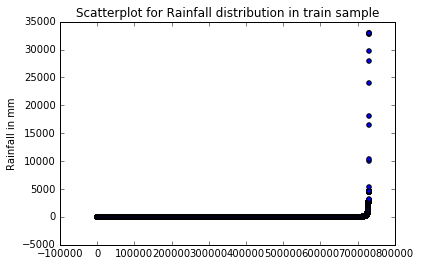

In [74]:
dfTrainGb = df.groupby(df.index)
exp_rainfall = np.sort(np.array(dfTrainGb['Expected'].aggregate('mean')))
plt.figure()
plt.scatter(np.arange(exp_rainfall.shape[0]), exp_rainfall)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Rainfall in mm")
plt.show()

### Premier modèle

Nous allons enlever l'information de séquence en gardant la moyenne de chaque dimensions obtenues par le radar et en enlevant la dimension minutes\_past tout en ajoutant la feature Marshall Palmer https://en.wikipedia.org/wiki/DBZ_(meteorology)

In [86]:
#dfTest = df[df.index < 10]

In [ ]:
%%time
def marshall_palmer(ref, minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in xrange(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0

    # sum up rainrate * validtime
    sum = 0
    for dbz, hours in zip(ref, valid_time):
        # See: http s://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    return sum

# each unique Id is an hour of data at some gauge
def myfunc(seq):
    #rowid = hour['Id'].iloc[0]
    # sort hour by minutes_past
    seq = seq.sort('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'], seq['minutes_past'])
    #print(type(seq.mean()))
    rslt = seq.mean()
    rslt['Marshall_Palmer'] = mp
    rslt = rslt.drop(['Id','minutes_past'])
    return rslt

dfFeatures = df.groupby(df.index).apply(myfunc)

#estimates.to_csv(outfile, header=True)

Combien y'a-t-il encore de valeurs NaN pour chaque dimension ?

In [92]:
dfFeatures.describe()

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected,Marshall_Palmer
count,731556.000000,731556.000000,634505.000000,705871.000000,731539.000000,731556.000000,645771.000000,709094.000000,731541.000000,557043.000000,...,557043.000000,490102.000000,544523.000000,595116.000000,515377.000000,446435.000000,503099.000000,557576.000000,731556.000000,731556.000000
mean,9.747146,21.336602,18.517741,21.181435,25.020293,23.008624,20.537947,22.874001,26.517257,0.976697,...,0.584581,-0.781790,0.246320,2.010008,0.043955,-3.608381,-0.793710,3.744939,23.994922,2.195731
std,4.059434,8.167739,7.454386,8.162825,8.821943,8.520330,7.875858,8.502780,9.126422,0.065238,...,1.038104,0.799990,0.786926,1.277317,2.650265,2.281614,1.937575,3.148840,241.450139,4.331871
min,0.000000,-28.416667,-30.166667,-28.583333,-24.250000,-25.166667,-28.000000,-25.416667,-22.583333,0.208333,...,-7.875000,-7.875000,-7.875000,-7.875000,-72.500000,-47.490005,-55.020004,-100.200005,0.010000,0.000000
25%,7.000000,16.000000,14.000000,15.750000,18.866667,17.166667,15.350000,17.000000,20.038462,0.969286,...,0.054688,-1.145833,-0.098214,1.281250,-0.702005,-4.550003,-0.940005,2.231813,0.254000,0.214487
50%,10.000000,21.045455,18.350000,20.950000,24.772727,22.625000,20.166667,22.500000,26.250000,0.990926,...,0.437500,-0.737500,0.218750,1.806818,0.028177,-3.175011,-0.242007,3.626358,1.270001,0.773172
75%,13.000000,26.800000,23.366667,26.700000,31.136364,28.791667,25.750000,28.666667,32.923077,1.005000,...,0.881250,-0.345588,0.546875,2.437500,0.789162,-2.113338,0.059161,5.213565,3.556002,2.314451
max,21.000000,59.500000,50.307692,56.000000,62.500000,91.500000,53.961538,58.500000,74.166667,1.051667,...,7.937500,7.937500,7.937500,7.937500,122.440000,1.629990,7.309998,82.509980,33017.730000,146.278694


Voyons si certaines features sont corrélées avec la dimension expected ?
> étonnemment toutes les features sont décorrélées deux à deux avec expected, même Marshall_Palmer

In [94]:
dfFeatures.corr()

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected,Marshall_Palmer
radardist_km,1.000000,0.069752,0.132316,0.064998,0.019148,-0.046264,-0.016114,-0.051791,-0.067415,0.367644,...,-0.204493,-0.194019,-0.351809,-0.262297,-0.004878,-0.325868,-0.167557,0.222136,0.030389,-0.096360
Ref,0.069752,1.000000,0.926084,0.977188,0.941408,0.958385,0.905778,0.942914,0.907492,0.162243,...,-0.121950,0.258910,0.044829,-0.247298,-0.007781,0.055542,0.155408,0.079802,-0.042359,0.616757
Ref_5x5_10th,0.132316,0.926084,1.000000,0.941992,0.874808,0.889300,0.941517,0.899110,0.837087,0.198396,...,-0.107254,0.269259,0.000976,-0.272781,-0.001668,0.045419,0.151442,0.101225,-0.013257,0.582364
Ref_5x5_50th,0.064998,0.977188,0.941992,1.000000,0.945030,0.949768,0.927672,0.962433,0.911212,0.163895,...,-0.117468,0.267182,0.045813,-0.255657,-0.007608,0.059386,0.161788,0.083436,-0.029461,0.613124
Ref_5x5_90th,0.019148,0.941408,0.874808,0.945030,1.000000,0.940908,0.881186,0.943271,0.970730,0.110324,...,-0.111431,0.235223,0.074810,-0.209900,-0.009987,0.054727,0.157469,0.070042,-0.047614,0.615435
RefComposite,-0.046264,0.958385,0.889300,0.949768,0.940908,1.000000,0.936063,0.980648,0.948133,0.113839,...,-0.100545,0.274127,0.090758,-0.212151,-0.013688,0.093727,0.167555,0.045447,-0.048284,0.619834
RefComposite_5x5_10th,-0.016114,0.905778,0.941517,0.927672,0.881186,0.936063,1.000000,0.949928,0.884113,0.142138,...,-0.084534,0.290101,0.065161,-0.235308,-0.008703,0.090754,0.165058,0.061011,-0.021823,0.588306
RefComposite_5x5_50th,-0.051791,0.942914,0.899110,0.962433,0.943271,0.980648,0.949928,1.000000,0.949503,0.111550,...,-0.095621,0.277443,0.091454,-0.216401,-0.013065,0.096867,0.171223,0.047103,-0.036889,0.618934
RefComposite_5x5_90th,-0.067415,0.907492,0.837087,0.911212,0.970730,0.948133,0.884113,0.949503,1.000000,0.072778,...,-0.094100,0.244466,0.104413,-0.181360,-0.014865,0.086583,0.163775,0.039806,-0.051287,0.615162
RhoHV,0.367644,0.162243,0.198396,0.163895,0.110324,0.113839,0.142138,0.111550,0.072778,1.000000,...,-0.235788,0.176840,-0.308004,-0.509879,0.041894,0.052654,-0.027173,0.073502,-0.016892,-0.008154


### Remplir les valeurs NaN



In [58]:
print(df.loc[4]['RhoHV_5x5_90th'].interpolate())
print(df.loc[4]['Zdr'].interpolate())
print(df.groupby(df.index)['Zdr'].interpolate())

Id_index
4    0.998333
4    0.999333
4    1.000333
4    1.001333
4    1.002333
4    1.003333
4    1.004333
4    1.005333
4    1.006333
4    1.007333
4    1.008333
4    1.005000
4    1.051667
Name: RhoHV_5x5_90th, dtype: float64
Id_index
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4      NaN
4   -1.125
Name: Zdr, dtype: float64


AttributeError: Cannot access callable attribute 'interpolate' of 'SeriesGroupBy' objects, try using the 'apply' method

In [ ]:
raw = raw[raw['Expected'] < 1000]

Dans un premier temps, on se contente de supprimer toutes les lignes contenant des données manquantes. On vérifie qu'on a toujours assez de données pour entrainer des premiers modèles.

Est ce que ces séquences correspondent à un Expected = 0 ?

Y'a t il des correlations importantes entre certaines dimensions ?
Et surtout, est ce que certaines dimensions sont positivement ou négativement corrélées avec la dimension à prédire ?

Nous effectuons un calcule de correlation pairwise avec la méthode de pearson.

## Premier modèle

On entraîne un premier modèle de régression linéaire, très simple, qui prend en entré un relevé ponctuel.
Comme on dispose de beaucoup de relevés et que l'apprentissage est long, on va sous échantillonner les données.

In [46]:
sample_size = len(dfTrain) / 10

sdfTrain = dfTrain.loc[np.random.permutation(dfTrain.index)[:sample_size]]

y = sdfTrain['Expected']
x = sdfTrain.drop(['Expected', 'Id'],1)

In [47]:
len(y)

276908

In [68]:
regr = linear_model.LinearRegression()

scores = np.zeros(5)

k = 0
for idEx in cross_validation.KFold(len(x.index), n_folds=5):
    xFoldTrain = x.iloc[idEx[0]]
    yFoldTrain = y.iloc[idEx[0]]
    xFoldTest = x.iloc[idEx[1]]
    yFoldTest = y.iloc[idEx[1]]
    regr.fit(xFoldTrain, yFoldTrain)
    scores[k] = mean_absolute_error(regr.predict(xFoldTest), yFoldTest)
    k = k + 1
#scores = cross_validation.cross_val_score(regr, x, y, cv=5, scoring=mean_absolute_error)

In [1]:
print scores.mean()
print scores.std()

NameError: name 'scores' is not defined

- Vérifier les valeurs abérantes au niveau des labels
- prétraitement des valeurs NaN avec EM (k-NN)


#Extractions de features

##Describe Ref